In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # Default seaborn theme, scaling & color palette
import pandas as pd

## Load & visualise the dataset

In [2]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


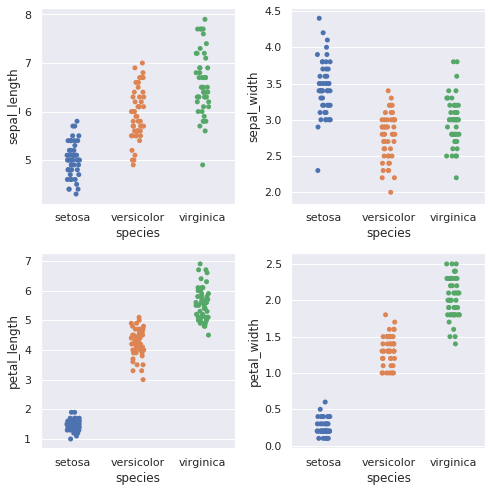

In [3]:
f, axes = plt.subplots(2, 2, figsize=(7, 7)) 
sns.stripplot(x='species', y='sepal_length', data=iris, ax=axes[0,0])
sns.stripplot(x='species', y='sepal_width', data=iris, ax=axes[0,1])
sns.stripplot(x='species', y='petal_length', data=iris, ax=axes[1,0])
sns.stripplot(x='species', y='petal_width', data=iris, ax=axes[1,1])
f.tight_layout()

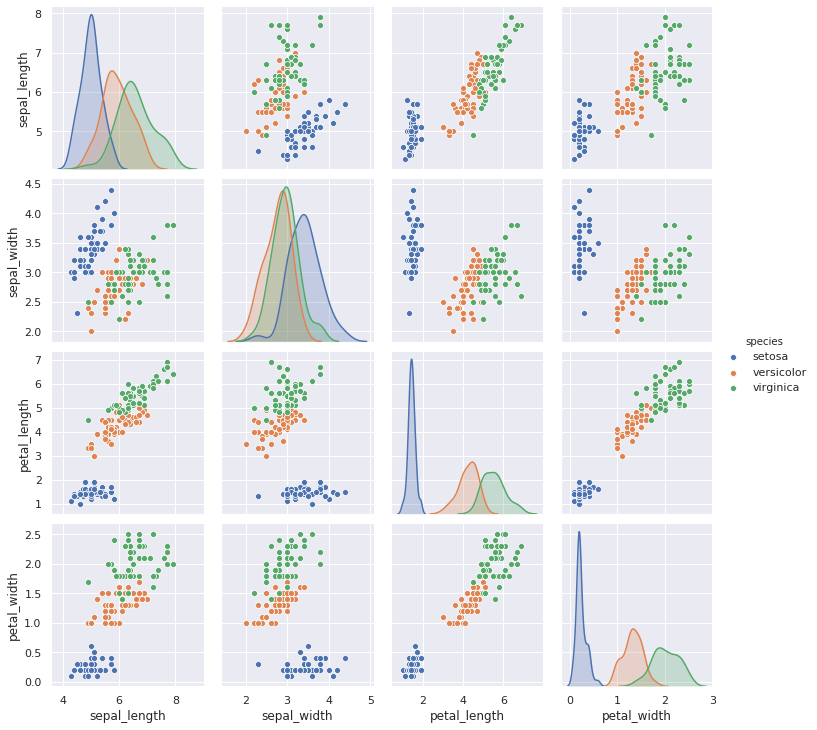

In [4]:
sns.pairplot(iris, hue='species', diag_kind='kde')

## Classify between setosa & versicolor using sepal length

In [5]:
# Just pick look at samples of setosa or versicolor flowers
df = iris[(iris.species == 'setosa') | (iris.species == 'versicolor')]
df['species'].unique()  # Now only have two categories

array(['setosa', 'versicolor'], dtype=object)

In [6]:
y_0 = pd.Categorical(df['species']).codes  # Encode the categories with codes 0, 1
x_0 = df['sepal_length'].values  # Just look at the sepal length feature

In [7]:
x_0.shape  # number data points

(100,)

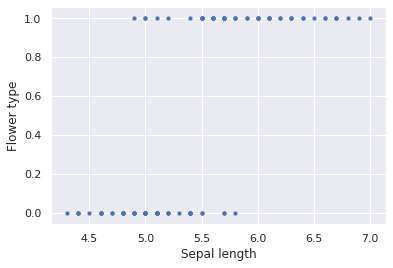

In [8]:
fig, ax = plt.subplots(1)
ax.scatter(x_0, y_0, s=10)
ax.set_xlabel('Sepal length')
ax.set_ylabel('Flower type')
plt.show()
# 0 = setosa, 1 = versicolor

## Build the model

In [9]:
import pymc3 as pm

In [10]:
model_0 = pm.Model()
with model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + pm.math.dot(x_0, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))  # Sigmoid
    bd = pm.Deterministic('bd', -alpha/beta)  # boundary decision - when prob = 1/2 (when sigmoid argument = 0: rearrange eqn)
    
    yl = pm.Bernoulli('yl', theta, observed=y_0)  # convert sigmoid output to a category via Bernoulli distribution   

In [11]:
with model_0:
    start = pm.find_MAP() 
    step = pm.NUTS()
    trace_0 = pm.sample(5000, step, start)

logp = -41.726, ||grad|| = 3.5299e-05: 100%|██████████| 23/23 [00:00<00:00, 2672.20it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:21<00:00, 1042.05draws/s]
The acceptance probability does not match the target. It is 0.9020220652344593, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/s

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb15528be90>,
      dtype=object)

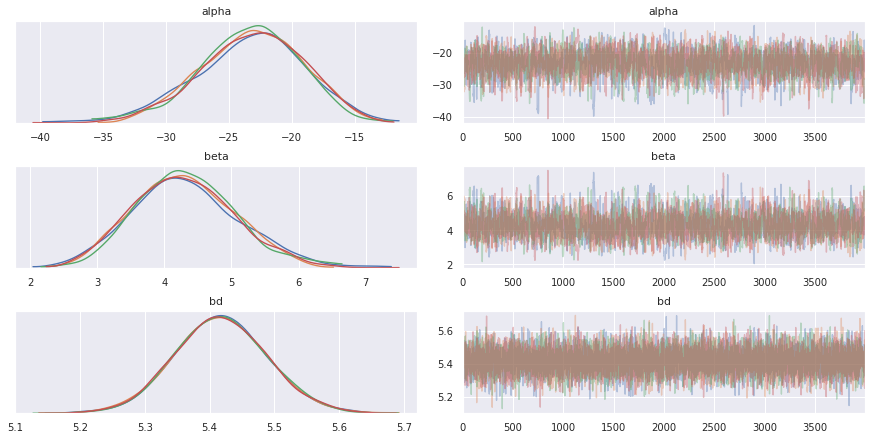

In [12]:
chain_0 = trace_0[1000:] 
varnames = ['alpha', 'beta', 'bd'] 
pm.traceplot(chain_0, varnames)

In [13]:
pm.summary(trace_0, varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-23.349,4.165,-31.060,-15.587,0.081,0.058,2636.0,2624.0,2625.0,2772.0,1.0
beta,4.312,0.772,2.940,5.809,0.015,0.011,2636.0,2623.0,2625.0,2870.0,1.0
bd,5.416,0.070,5.288,5.551,0.001,0.000,15894.0,15881.0,15888.0,14189.0,1.0


## Look at the posterior

In [14]:
import numpy as np

In [15]:
# theta: 5000 samples x 4 chains, 100 data points
theta = trace_0['theta'].mean(axis=0)  # average over the samples
theta.shape  # get a theta per input feature value

(100,)

Text(0, 0.5, 'theta')

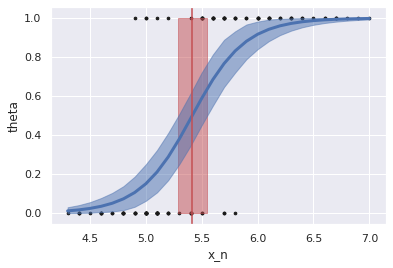

In [23]:
idx = np.argsort(x_0)  # indicies that would sort the array in order of sepal length (so plot function looks nice)

plt.plot(x_0[idx], theta[idx], color='b', lw=3)
plt.scatter(x_0, y_0, color='k', s=7)  # some overlap in these values - 100 plotted in total

plt.axvline(trace_0['bd'].mean(), ymax=1, color='r')  # decision boundary

bd_hpd = pm.hpd(trace_0['bd'])  # minimum width credible interval for decision boundary - 94%
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)


theta_hpd = pm.hpd(trace_0['theta'])[idx]  # ordered in terms of sepal length
plt.fill_between(x_0[idx], theta_hpd[:, 0], theta_hpd[:, 1], color='b', alpha=0.5)

plt.xlabel('x_n') 
plt.ylabel('theta')

## Classify some flowers

In [21]:
def classify(n, threshold): 
    """
    A simple classifying function
    n: array of sepal lengths
    threshold: value of theta for decision boundary
    """
    n = np.array(n)
    mu = trace_0['alpha'].mean() + trace_0['beta'].mean() * n 
    prob = 1 / (1 + np.exp(-mu)) 
    
    return prob, prob > threshold  # return both the prob and the class

In [22]:
classify([5, 5.5, 6], 0.5)

(array([0.14302019, 0.59034624, 0.92561626]), array([False,  True,  True]))